In [1]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import h5py
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
model_checkpoint_save_path = './models/checkpoints/'
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dtype)
print(device)

torch.float32
cuda:0


# Connect Colab and Google Drive

In [3]:
# Path to where deeplearningproject is stored on drive that contains the data and the git repo (may have to be changed depending on user)
# Note can just use Colab terminal with git commands to commit, pull, push, etc. (Note have to follow this to push: https://stackoverflow.com/a/65951928/14018615)
deep_learn_drive_path = '/content/drive/MyDrive/CS 6955/deeplearningproject/'
# To use with colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# cd into git repo
os.chdir(deep_learn_drive_path + 'cs-6955-deep-learning-final-project')
print('Git directory content: {0}'.format(os.listdir()))

Git directory content: ['porositydata_howto.py', '.git', 'README.md', '.gitignore', 'porositydataset.hdf5', 'predicting_porous_materials_mechanical_response.ipynb', 'models']


# Visualize Data

In [5]:
##load the dataset
d = h5py.File('porositydataset.hdf5','a')
print(d.keys())
#load original images
og_images = np.zeros(d['Original Images'].shape)
og_images[:,:,:] = d['Original Images']
#load deformed images
deformed_images = np.zeros(d['Deformed Images'].shape)
deformed_images[:,:,:] = d['Deformed Images']
#load stress-strain data
data = np.zeros(d['Data'].shape)
data[:,:,:] = d['Data']
#separate stresses/strains, stresses in MPa, strain is unitless
SMises = data[:,0,:] #von Mises stress
S11 = data[:,1,:] #stress in 11 direction
S22 = data[:,2,:] #stress in 22 direction
SP = data[:,3,:] #pressure stress
strain = data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
#load youngs moduli, units are GPa
E = np.zeros(d['Youngs Modulus'].shape)
E[:] = d['Youngs Modulus']


<KeysViewHDF5 ['Data', 'Deformed Images', 'Original Images', 'Youngs Modulus']>


Youngs Modulus: 0.0001933745907298482 GPa
(1000, 256, 256, 3)


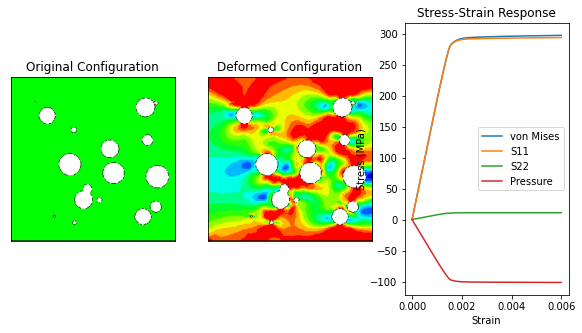



Youngs Modulus: 0.00016008156459853504 GPa
(1000, 256, 256, 3)


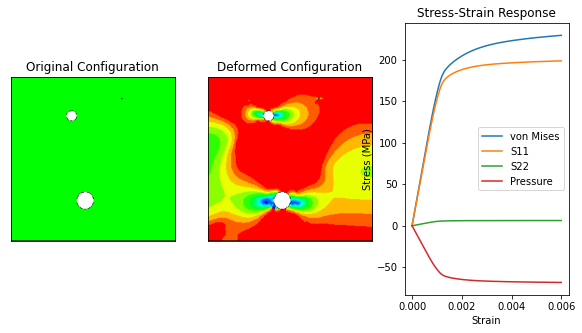



Youngs Modulus: 0.00016606028361832527 GPa
(1000, 256, 256, 3)


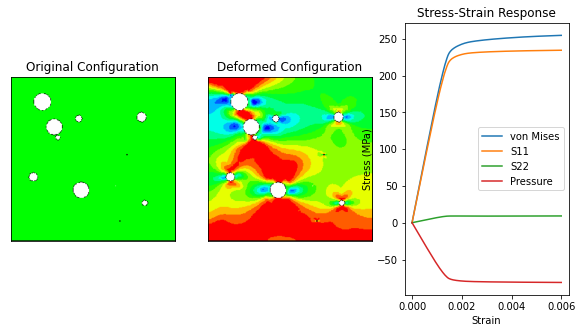



Youngs Modulus: 0.00018398679582705882 GPa
(1000, 256, 256, 3)


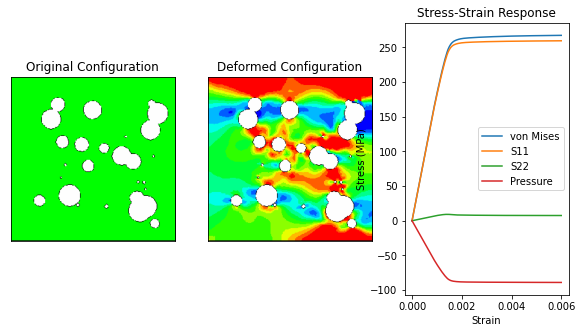



Youngs Modulus: 0.0001502345350259747 GPa
(1000, 256, 256, 3)


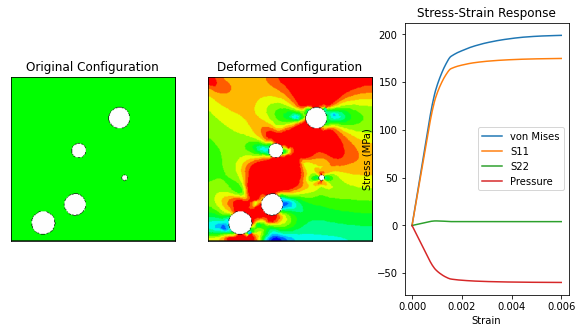

In [6]:
for _ in range(5):
    #choose which run you want to look at
    run = random.randint(0, E.size-1)
    #print youngs modulus
    print('Youngs Modulus:',E[run],'GPa')
    #plot images and stress response
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.imshow(og_images[run,:,:,:].astype('uint8'))
    print(og_images.shape)
    ax1.title.set_text('Original Configuration')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(deformed_images[run,:,:,:].astype('uint8'))
    ax2.title.set_text('Deformed Configuration')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.plot(strain[run,:],SMises[run,:],label='von Mises')
    ax3.plot(strain[run,:],S11[run,:],label='S11')
    ax3.plot(strain[run,:],S22[run,:],label='S22')
    ax3.plot(strain[run,:],SP[run,:],label='Pressure')
    ax3.title.set_text('Stress-Strain Response')
    ax3.set_xlabel('Strain')
    ax3.set_ylabel('Stress (MPa)')
    ax3.legend()
    plt.show()
    print()
    print()

# Create PyTorch Dataset 

In [7]:
class PorousMaterialsDataset(Dataset):
    def __init__(self, hdf5_porosity_path, img_transform=None):
        self.img_transform = img_transform
        ##load the dataset
        self.d = h5py.File(hdf5_porosity_path,'a')
        #load original images
        self.og_images = np.zeros(self.d['Original Images'].shape)
        self.og_images[:,:,:] = self.d['Original Images']
        #load deformed images
        self.deformed_images = np.zeros(self.d['Deformed Images'].shape)
        self.deformed_images[:,:,:] = self.d['Deformed Images']
        #load stress-strain data
        self.ss_data = np.zeros(self.d['Data'].shape)
        self.ss_data[:,:,:] = self.d['Data']
        #separate stresses/strains, stresses in MPa, strain is unitless
        self.SMises = self.ss_data[:,0,:] #von Mises stress
        self.S11 = self.ss_data[:,1,:] #stress in 11 direction
        self.S22 = self.ss_data[:,2,:] #stress in 22 direction
        self.SP = self.ss_data[:,3,:] #pressure stress
        self.strain = self.ss_data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
        #load youngs moduli, units are GPa
        self.E = np.zeros(self.d['Youngs Modulus'].shape)
        self.E[:] = self.d['Youngs Modulus']
        
    def __len__(self):
        return self.E.size

    def __getitem__(self, idx):
        og_image_idx = self.og_images[idx,:,:,:].astype('uint8')
        deformed_image_idx = self.deformed_images[idx,:,:,:].astype('uint8')
        if (self.img_transform is not None):
            og_image_idx = self.img_transform(og_image_idx)
            deformed_image_idx = self.img_transform(deformed_image_idx)
        SMises_idx = self.SMises[idx,:]
        S11_idx = self.S11[idx,:]
        S22_idx = self.S22[idx,:]
        SP_idx = self.SP[idx,:]
        strain_idx = self.strain[idx,:]
        E_idx = self.E[idx]
        # return og_image_idx, SMises_idx, S11_idx, S22_idx, SP_idx, SP_idx, strain_idx, E_idx
        # Have to decide what exactly to return here, depends on training task
        # For now will have og_image_idx be the feature and E_idx be the label
        image = og_image_idx
        label = E_idx
        return image, label

In [8]:
# Load porous dataset into memory
porous_dataset = PorousMaterialsDataset('porositydataset.hdf5', img_transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(224), transforms.ToTensor()]))

In [16]:
# Split into train and test
test_prop = 0.2
test_size = int(test_prop*len(porous_dataset))
train_size = len(porous_dataset) - test_size
porous_train_dataset, porous_test_dataset = random_split(porous_dataset, (train_size, test_size)) 

# Split train into train and val
val_prop = 0.2
val_size = int(val_prop*len(porous_train_dataset))
train_size = len(porous_train_dataset) - val_size
porous_train_dataset, porous_val_dataset = random_split(porous_train_dataset, (train_size, val_size)) 

In [17]:
batch_size = 32
train_loader = DataLoader(porous_train_dataset, batch_size=batch_size, shuffle=True)

# Batch size doesn't really matter for testing
test_loader = DataLoader(porous_test_dataset)
val_loader = DataLoader(porous_val_dataset)

Label: 0.00015004711202139682 GPa
torch.Size([3, 224, 224])


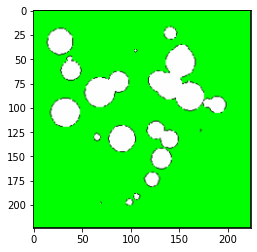



Label: 0.00017756376760724306 GPa
torch.Size([3, 224, 224])


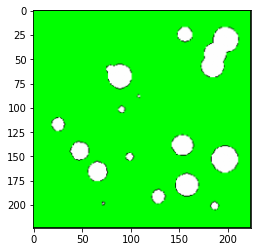



Label: 0.0001596850009039636 GPa
torch.Size([3, 224, 224])


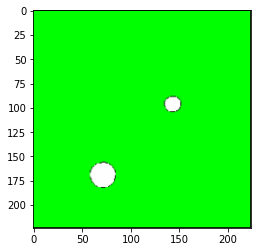



Label: 0.00019467498444767568 GPa
torch.Size([3, 224, 224])


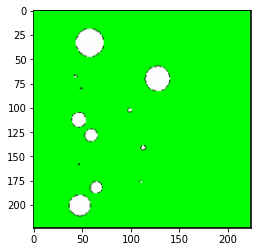



Label: 0.00017832148408678517 GPa
torch.Size([3, 224, 224])


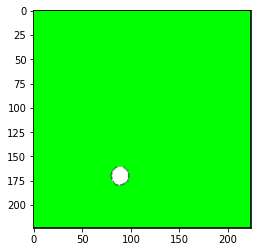



Label: 0.00019536298881723965 GPa
torch.Size([3, 224, 224])


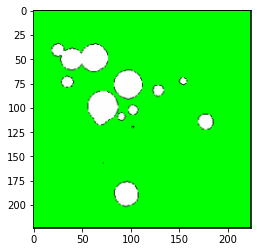



Label: 0.00018140148626914052 GPa
torch.Size([3, 224, 224])


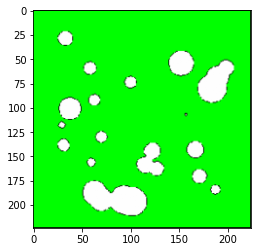



Label: 0.00016748750043402743 GPa
torch.Size([3, 224, 224])


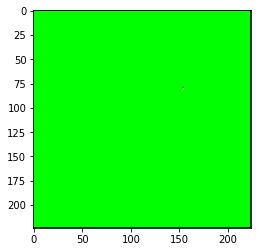



Label: 0.00017377057020933812 GPa
torch.Size([3, 224, 224])


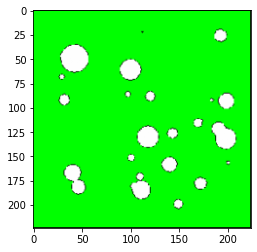



Label: 0.00019603088347690275 GPa
torch.Size([3, 224, 224])


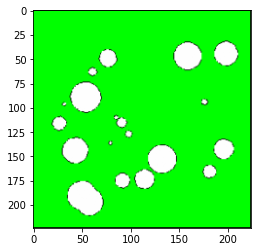



Label: 0.00014069338901127155 GPa
torch.Size([3, 224, 224])


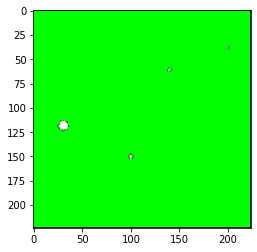



Label: 0.000163267289861289 GPa
torch.Size([3, 224, 224])


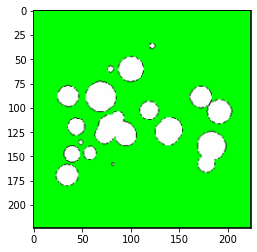



Label: 0.00016308050732700646 GPa
torch.Size([3, 224, 224])


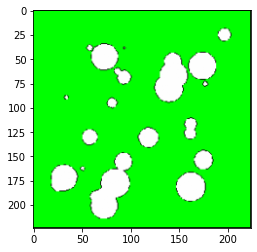



Label: 0.00018456706850054645 GPa
torch.Size([3, 224, 224])


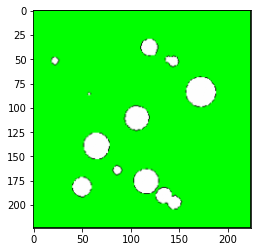



Label: 0.0002020920990698816 GPa
torch.Size([3, 224, 224])


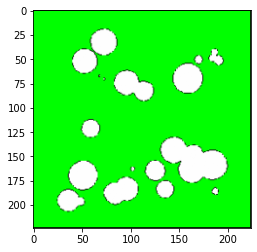



Label: 0.00016598160745237103 GPa
torch.Size([3, 224, 224])


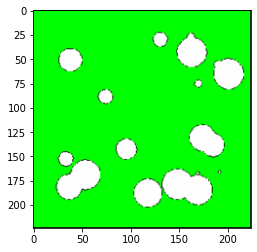



Label: 0.00017764697084304997 GPa
torch.Size([3, 224, 224])


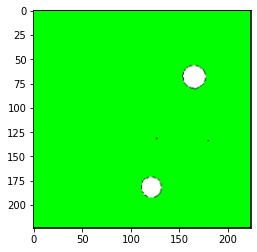



Label: 0.00015437476831571791 GPa
torch.Size([3, 224, 224])


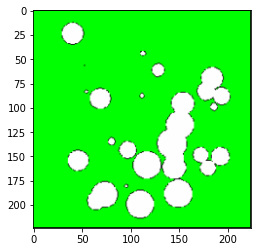



Label: 0.00017200641784686165 GPa
torch.Size([3, 224, 224])


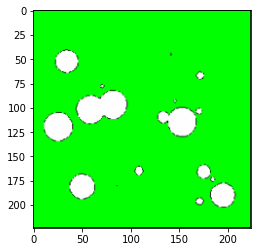



Label: 0.0001640360968865187 GPa
torch.Size([3, 224, 224])


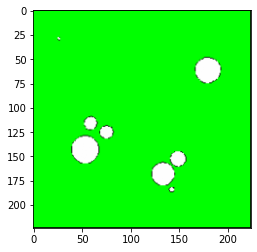



Label: 0.00016560354378357192 GPa
torch.Size([3, 224, 224])


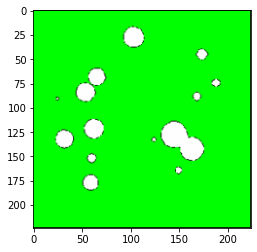



Label: 0.0001906904431224336 GPa
torch.Size([3, 224, 224])


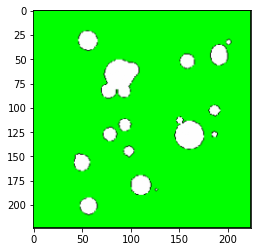



Label: 0.0001727051485989081 GPa
torch.Size([3, 224, 224])


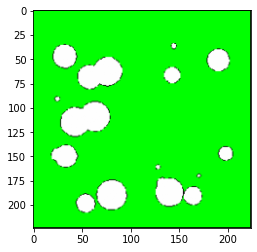



Label: 0.0001410766559058247 GPa
torch.Size([3, 224, 224])


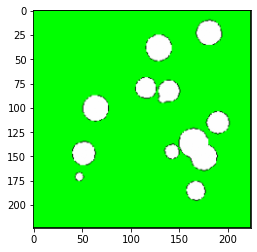



Label: 0.00019170920195091864 GPa
torch.Size([3, 224, 224])


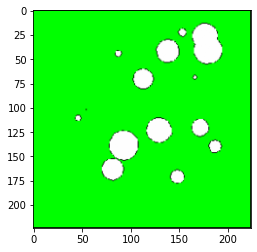



Label: 0.00016644327043243177 GPa
torch.Size([3, 224, 224])


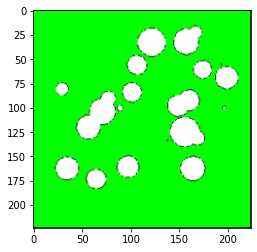



Label: 0.00016477904598092462 GPa
torch.Size([3, 224, 224])


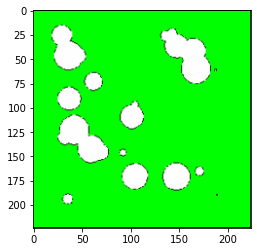



Label: 0.00019058989038914988 GPa
torch.Size([3, 224, 224])


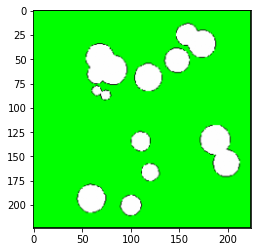



Label: 0.00019996058486232188 GPa
torch.Size([3, 224, 224])


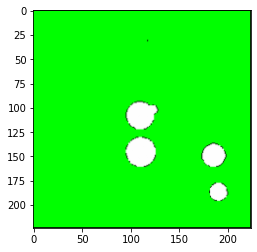



Label: 0.00018334179636300278 GPa
torch.Size([3, 224, 224])


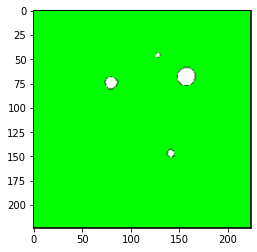



Label: 0.00014199386547927062 GPa
torch.Size([3, 224, 224])


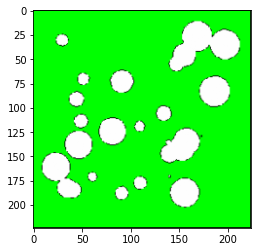



Label: 0.00015386323959393742 GPa
torch.Size([3, 224, 224])


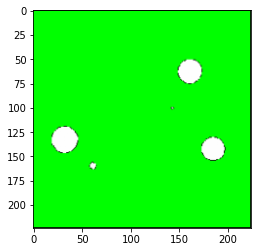

In [18]:
# Visualize train data of a random batch 
viz_batch_idx = random.randint(0, len(train_loader)-1)
for i, batch in enumerate(train_loader):
    if i != viz_batch_idx:
        continue
    train_features, train_labels = batch
    for idx in range(len(train_features)):
        print("Label: {0} GPa".format(train_labels[idx].item()))
        plt.figure()
        print(train_features[idx].shape)
        plt.imshow(torch.movedim(train_features[idx], 0, 2))
        plt.show()
        print()
        print()


# Training

In [20]:
class PorousMaterialImageToYoungsModulusNet(nn.Module):
    def __init__(self):
        super().__init__()
        squeeze_net_model = nn.Sequential(*list(models.squeezenet1_1(pretrained=False).children()))
        self.model = torch.nn.Sequential(
            squeeze_net_model,
            nn.Flatten(),
            nn.Linear(1000, 1)
            )

    def forward(self, porous_material_image):
        scores = self.model(porous_material_image)
        return torch.flatten(scores, start_dim=1, end_dim=1)



In [21]:
def get_PorousMaterialImageToYoungsModulusNet_accuracy(model, evaluation_dataloader, criterion):
    model.eval()
    model = model.to(device=device)
    total_MSE = 0
    num_vals = 0
    with torch.no_grad():
        for eval_val in evaluation_dataloader:
            feat, label, = eval_val
            feat = feat.to(dtype=dtype, device=device)
            label = label.to(dtype=dtype, device=device)

            pred_label = torch.flatten(model(feat))
            total_MSE += criterion(pred_label, label).cpu().item()
            num_vals += 1
    avg_MSE = total_MSE / num_vals
    return total_MSE, avg_MSE 

In [34]:
model = PorousMaterialImageToYoungsModulusNet()

learning_rate = 1e-3
nepochs = 100
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
train_total_MSE_vals = []
val_total_MSE_vals = []
model_save_name = 'model.pt'
model_save_path = '{0}{1}'.format(model_checkpoint_save_path, model_save_name)
best_val_total_MSE = 1 # Only want to start saving best model once below this 
model = model.to(device=device)
model.train()
for e in range(nepochs):
    print("Begin epoch {0}".format(e))
    for batch in train_loader:
        train_features, train_labels = batch
        train_features = train_features.to(dtype=dtype, device=device)
        train_labels = train_labels.to(dtype=dtype, device=device)

        pred_labels = torch.flatten(model(train_features))
        loss = criterion(pred_labels, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    current_train_total_MSE, _ = get_PorousMaterialImageToYoungsModulusNet_accuracy(model, train_loader, criterion)
    current_val_total_MSE, _ = get_PorousMaterialImageToYoungsModulusNet_accuracy(model, val_loader, criterion)
    train_total_MSE_vals.append(current_train_total_MSE)
    val_total_MSE_vals.append(current_val_total_MSE)
    if current_val_total_MSE < best_val_total_MSE:
        torch.save({
            'epoch':e,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'train_loss':current_train_total_MSE,
            'val_loss':current_val_total_MSE
        }, model_save_path)
        best_val_total_MSE = current_val_total_MSE
    print("Epoch {0}: train total MSE={1}, val total MSE={2}\n\n".format(e, current_train_total_MSE, current_val_total_MSE))

Begin epoch 0
Epoch 0: train total MSE=1.583774024993545e-05, val total MSE=0.00012654837280479114


Begin epoch 1
Epoch 1: train total MSE=8.464750278491806e-08, val total MSE=7.145226484805791e-07


Begin epoch 2
Epoch 2: train total MSE=3.969834605488387e-08, val total MSE=3.387204610734761e-07


Begin epoch 3
Epoch 3: train total MSE=4.175543522055847e-08, val total MSE=3.5465770924789433e-07


Begin epoch 4
Epoch 4: train total MSE=3.598314401997982e-08, val total MSE=3.124393564519427e-07


Begin epoch 5
Epoch 5: train total MSE=3.444871521374182e-08, val total MSE=2.9562268971572993e-07


Begin epoch 6
Epoch 6: train total MSE=3.2767791646737265e-08, val total MSE=2.7929620097446884e-07


Begin epoch 7
Epoch 7: train total MSE=3.266125048195789e-08, val total MSE=2.7768503714323977e-07


Begin epoch 8
Epoch 8: train total MSE=3.046786001270618e-08, val total MSE=2.5673782155413096e-07


Begin epoch 9
Epoch 9: train total MSE=2.925285841337555e-08, val total MSE=2.440705880038162

## Display Training Results

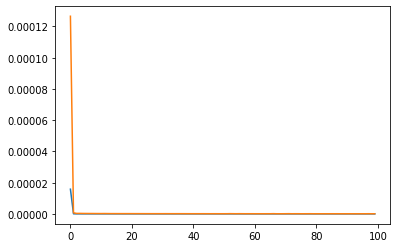

In [40]:
plt.figure()
plt.plot(train_total_MSE_vals, label='Test MSE')
plt.plot(val_total_MSE_vals, label='Test MSE')
plt.show()

In [41]:
best_model = PorousMaterialImageToYoungsModulusNet()
best_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_checkpoint = torch.load(model_save_path)
best_epoch = best_checkpoint['epoch']
best_model.load_state_dict(best_checkpoint['model_state_dict'])
best_optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
best_train_loss = best_checkpoint['train_loss']
best_val_loss = best_checkpoint['val_loss']

print('Best epoch={0}, best train total MSE loss{1}, best val total MSE loss{2}'.format(best_epoch, best_train_loss, best_val_loss))

Best epoch=94, best train total MSE loss1.128057464105936e-08, best val total MSE loss1.0636710382357876e-07


## Test Results

In [42]:
test_total_MSE, test_avg_MSE = get_PorousMaterialImageToYoungsModulusNet_accuracy(best_model, test_loader, criterion)
print('Best val set model: test total MSE={0}GPa**2, test avg MSE={1}GPa**2'.format(test_total_MSE, test_avg_MSE))

Best val set model: test total MSE=1.3980414873260148e-07GPa**2, test avg MSE=6.990207436630073e-10GPa**2
